# Sat Chirp Backgrounder
By Terry Bondy, VA3TYB

In [42]:
printf(strftime ("Last updated: %A %e %B %Y", localtime (time ())))

Last updated: Monday 14 October 2019

$$
\today
$$
# Scope
What is described here is background for a means of determining the 
instantaneous translating properties of a linear satellite by sending 
a single brief 'chirp' in the uplink and listening across the satellite band 
for the downlink with an SDR and doing some processing. These translation 
properties include:
* The instantaneous tranlation frequency,
* Whether the downlink is USB or LSB.

# Producing This Document
This document is produced using *Octave*, an open source tool very similar to
*Matlab*. The lines in the boxes are *Octave* commands to create the 
mathematical examples that are used.

# A Brief Review of Signal Analysis In The Time and Frequency Domains 
Consider a 20 Hz wave modulated by a triangular pulse over one second 
sampled at 48 kHz (Figure 1).

Create a vector of times between 
-0.5 and 0.5 at 1/48000 intervals

In [43]:
T = [ -0.5 : 1/48000 : 0.5]; 

Create a vector of voltages for those times

In [44]:
V_of_t = 2 * cos(2*pi*20*T) .* (0.5 - abs(T));

...and then plot the voltage in the time domain

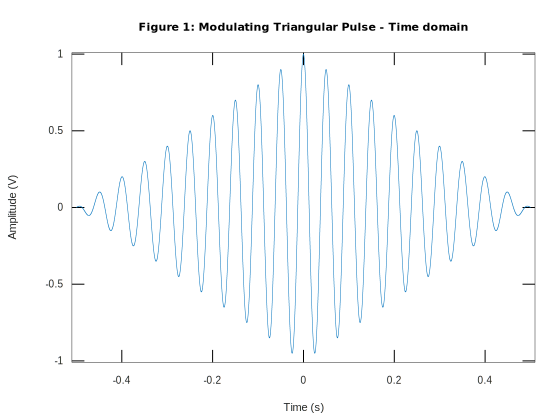

In [45]:
%plot --format svg
plot(T, V_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 1: Modulating Triangular Pulse - Time domain")
axis([-0.51 0.51 -1.01 1.01])

Now do an FFT to determine the frequency components of the signal (Figure 2).

Use |fft| to do an analysis of the time signal in the 
frequency domain. Use |fftshift| to shift 0 Hz to the 
centre of the vector

In [46]:
V_of_f = fftshift(fft(V_of_t, (size(V_of_t,2)-1)*10+1)/(size(V_of_t,2)/2));

Create a vector of frequencies for plotting

In [47]:
F = [-24000: 1/10: 24000];

...and then plot the voltage in the frequency domain

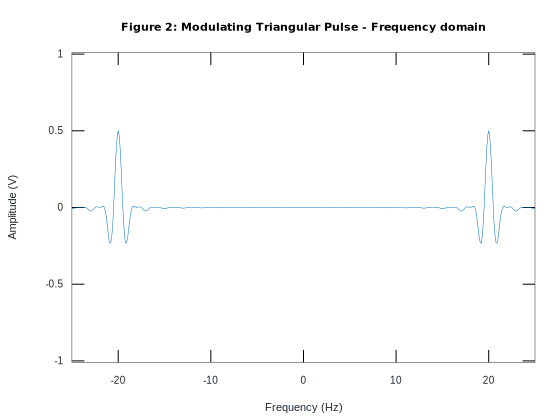

In [48]:
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 2: Modulating Triangular Pulse - Frequency domain")
axis([-25 25 -1.01 1.01])

It can be seen from the graph that the primary components consist of
frequencies at and around +20 Hz and -20 Hz.

Note that real value signals
will have +ve and -ve frequency components.

The same process can be used
with complex phasors by using |exp(i*2*pi*20*T)| or |exp(-i*2*pi*20*T)| in 
place of |cos(2*pi*20*T)|. For the +ve phasor the time signal looks the 
same (Figure 3).

Create a vector of voltages for those times

In [49]:
V_of_t = 2 * exp(i*2*pi*20*T) .* (0.5 - abs(T));

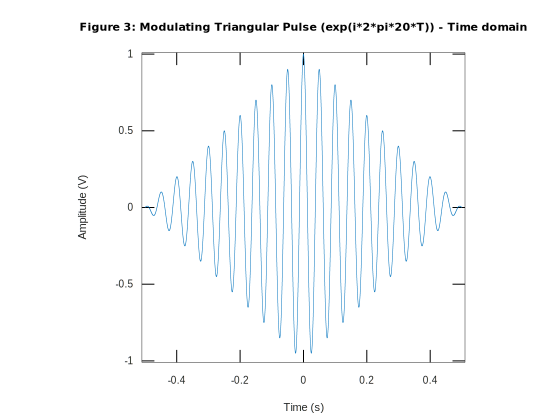

In [50]:
plot(T, V_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 3: Modulating Triangular Pulse (exp(i*2*pi*20*T)) - Time domain")
axis('square')
axis([-0.51 0.51 -1.01 1.01])

The FFT is calculated again (Figure 4).

In [51]:
V_of_f = fftshift(fft(V_of_t, (size(V_of_t,2)-1)*10+1)/(size(V_of_t,2)/2));

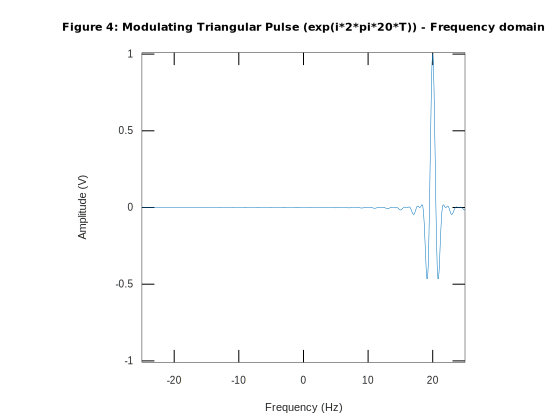

In [52]:
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 4: Modulating Triangular Pulse (exp(i*2*pi*20*T)) - Frequency domain")
axis('square')
axis([-25 25 -1.01 1.01])

Looking at the FFT there is only one sideband, the USB. Also, the
component has twice the energy of the previos two, representing conservation
of energy.

Now for $exp(-i*2*pi*20*T)$ (Figure 5). 

Create a vector of voltages for those times

In [53]:
V_of_t = 2 * exp(-i*2*pi*20*T) .* (0.5 - abs(T));

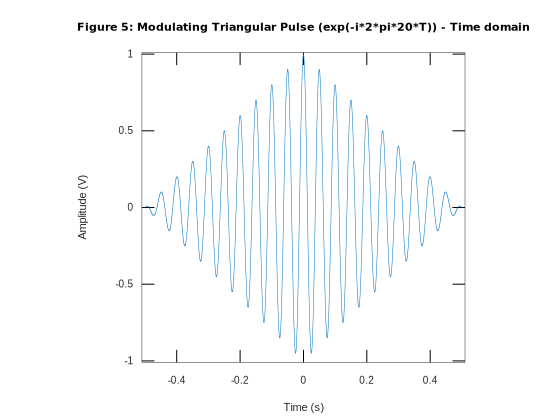

In [54]:
plot(T, V_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 5: Modulating Triangular Pulse (exp(-i*2*pi*20*T)) - Time domain")
axis('square')
axis([-0.51 0.51 -1.01 1.01])

The FFT is calculated (Figure 6).

In [55]:
V_of_f = fftshift(fft(V_of_t, (size(V_of_t,2)-1)*10+1)/(size(V_of_t,2)/2));

In [56]:
F = [-24000: 1/10: 24000];

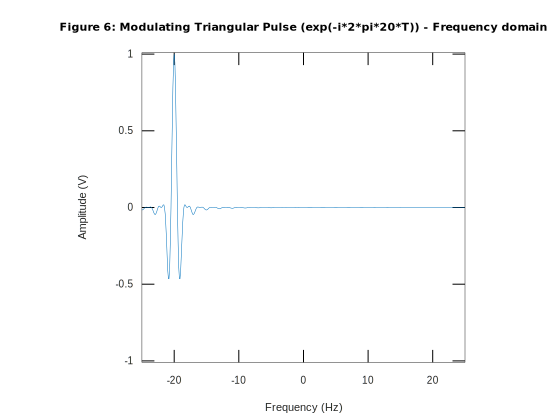

In [57]:
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 6: Modulating Triangular Pulse (exp(-i*2*pi*20*T)) - Frequency domain")
axis('square')
axis([-25 25 -1.01 1.01])

Looking at the FFT there is only one sideband, the LSB.

# Strategy for Determining Downlink Frequency of the Uplink Chirp
To further describe the strategy for determining the downlink frequency
of the uplink chirp, the SDR will receive the complete satellite downlink
band and do processing on it. It will look at the _frequency_ representation
of the chirp that is decided on and determine it frequency offset.

In order to determine the frequency offset, the process will use a 
[matched filter](https://en.wikipedia.org/wiki/Matched_filter). An example
of a matched filter will demonstrate the two properties that will make it 
useful for this process:
* It is easy to determine whether the signal originating the matched filter is present,
* It is easy to determine when the signal originating the matched filter has completed.

For this example a cosine pulse starting at 0 s and ending at 1s

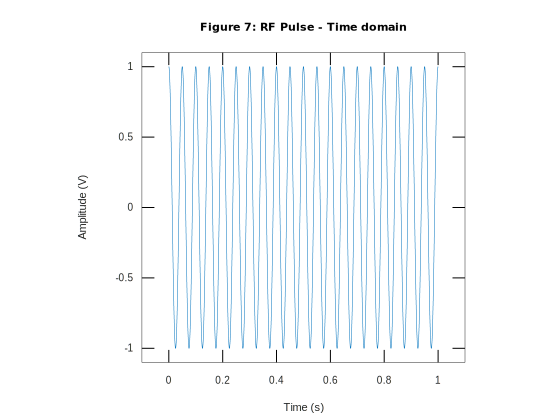

In [58]:
T = [0: 1/48000: 1];
V_of_t = cos(2*pi*20*T);

plot(T, V_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 7: RF Pulse - Time domain")
axis('square')
axis([-0.1 1.1 -1.1 1.1])

As it turns out the matched filter is the time reversed version of the
signal, which is the signal itself.

The output of the filter is determined by convolving the input signal
with the matched filter. For the first part of the example, the input
is the signal itself followed by 4 sec of silence

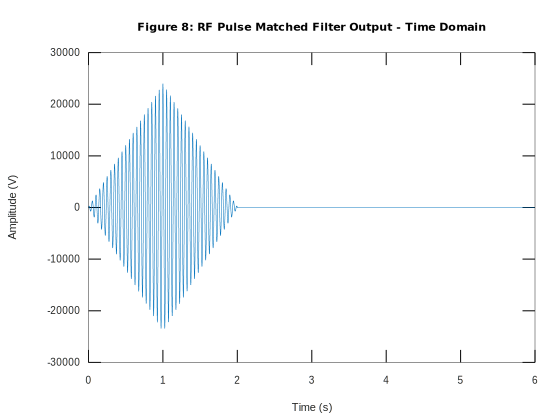

In [59]:
V_input = horzcat(V_of_t, zeros(1, 48000*4));
O_of_t = conv(V_of_t, V_input);
T_of_output = [0: 1/48000: (size(O_of_t,2)-1)/48000];
plot(T_of_output, O_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 8: RF Pulse Matched Filter Output - Time Domain")

The peak of the envelope determines where RF pulse ends.

For the next part of the example, it will be determined if the signal
can be detected in the presence of noise. First come up with
the input signal with the noise at a SNR = -20 (Figure 9).

In [60]:
snr = -20; # dB
# Linearize the SNR
snr_lin = 10^(snr/10);
# Determine the original signal power
e_sig = sum(abs(V_of_t).^2)/size(V_of_t,2);
# And then get noise spectral density
n_0 = e_sig/snr_lin;
n_sigma = sqrt(n_0);

V_noise = n_sigma * randn(1,size(V_input,2));

In [61]:
V_signal = V_input .+ V_noise;
plot([0: 1/48000: (size(V_signal,2)-1)/48000], V_signal)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 9: RF Pulse with Noise - Time Domain")
axis('square')

Can you see the pulse amongst the noise? Lets plot them next to each other
for magnitude comparision (Figure 10).

In [ ]:
V_compare = horzcat(V_input, V_noise);
plot([0: 1/48000: (size(V_compare,2)-1)/48000], V_compare)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 10: Magnitude Comparision of RF Pulse and Noise - Time Domain")
axis('square')

Finally lets examine the matched filter output (Figure 11).

In [ ]:
O_of_t = conv(V_of_t, V_signal);
plot(T_of_output, O_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 10: RF Pulse Matched Filter Output with Noise - Time Domain")
axis('square')

So even though the RF pulse is 20 dB less than the noise, the pulsed filter
is able to pull it out.

So far in the examples a matched filter is shown working in the time domain.
Matched filters can also be used in the frequency domain. In this case it
is possible to determine the frequency offset of the signal. The process
is the following:
* RF pulse -> FFT -> flip in frequency = matched filter
* input signal -> FFT -> convolve with matched filter = matched filter output

There is a property in time/frequency analysis that can be brought to bear,
specifically convolution of two signals in one domain is multiplication in
the other. So now the process becomes:
* RF pulse -> FFT -> flip in frequency -> reverse FFT -> matched filter in time domain
* input signal -> muly by matched filter in time domain -> FFT = matched filter output

For the example we are going to use the 20 Hz RF pulse, but just the USB.
Examine first the matched filter in the time domain (Figure 11).

In [ ]:
T = [0: 1/48000: 1];
V_of_t = exp(2*i*pi*20*T);
V_input = horzcat(V_of_t, zeros(1, 48000*4));
MatchedFilter_of_t = ifft(flip(fft(V_input)));
plot([0: 1/48000: (size(MatchedFilter_of_t,2)-1)/48000], MatchedFilter_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 11: Matched Filter - Time Domain")
axis('square')

So now lets use the same pulse, but shift its frequency to 120 Hz and
add some noise, multiply by the matched filter, then look at a plot of the
FFT.

In [ ]:
V_of_t = exp(2*i*pi*120*T);
V_input = horzcat(V_of_t, zeros(1, 48000*4));


snr = -20; # dB
# Linearize the SNR
snr_lin = 10^(snr/10);
# Determine the original signal power
e_sig = sum(abs(V_of_t).^2)/size(V_of_t,2);
# And then get noise spectral density
n_0 = e_sig/snr_lin;
n_sigma = sqrt(n_0);

V_noise = n_sigma * randn(1,size(V_input,2));
V_signal = V_input .+ V_noise; # Use the same noise from the other example
V_signal_2 = V_signal .* MatchedFilter_of_t;
V_of_f = fft(V_signal_2)/(size(V_signal_2,2)/2);

In [ ]:
F = [0: 1/5: (size(V_signal_2)-1)/5]; # 5 comes from legth of sample in time
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 6: Modulating Triangular Pulse (exp(-i*2*pi*20*T)) - Frequency domain")
axis('square')